In [26]:
#%%capture
%load_ext line_profiler
%matplotlib inline


# Had to install this funcy dependency manually, there was a bug in cadCAD, where the dependency wasn't loaded
# import sys
# !{sys.executable} -m pip install --user funcy

# instal line profiler, for optimizing notebook
# !pip install --user line_profiler


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
import importlib
import utils
from numpy.random import rand

importlib.reload(utils)



The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


<module 'utils' from '/home/jupyter-brennekamp/utils.py'>

In [55]:
%%time
import os.path
import networkx as nx

num_runs = 1

params = {}

num_timesteps = 3
simulation_parameters = {
    'T': range(num_timesteps),
    'N': num_runs,
    'M': params
}


# initialized_conditions = {}

initialized_conditions = {
    's': {
        'integer': 0,
        'network': None,
        'networkLength': 0,
        'networkLengthx2': 0
    }
}
    
def initialPolicy(params, step, sL, s):
    print('initialPolicy')
    g = utils.getNetwork()
    s['s']['network'] = g

    return {"policy": None}

def initialStateUpdateFunction(params, step, sL, s, _input):
    print('initialStateUpdateFunction')
    g = utils.getNetwork()
    g.add_node(utils.genuid(g))
    s['s']['network'] = g
    s['s']['networkLength'] = len(g)
    
    utils.saveNetwork(g)
    s['s']['network'] = None
    return ('s', s['s'])

def subsequentStateUpdateFunction(params, step, sL, s, _input):
    print('subsequentStateUpdateFunction')
    g = utils.getNetwork()
    s['s']['network'] = g
    s['s']['networkLengthx2'] = len(g) * 2
    
    utils.saveNetwork(g)
    s['s']['network'] = None
    return ('s', s['s'])


# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# In the Partial State Update Blocks, 
# the user specifies if state update functions will be run in series or in parallel
# and the policy functions that will be evaluated in that block
partial_state_update_blocks = [
    {
        'policies': {
            'initialPolicy': initialPolicy
        },
        'variables':{
            's': initialStateUpdateFunction
        }
    },
    {
        'policies': {
            'initialPolicy': initialPolicy
        },
        'variables':{
            's': subsequentStateUpdateFunction
        }
    }
]

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



from cadCAD.configuration import Configuration
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initialized_conditions.copy(), #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

from cadCAD import configs

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results

single_proc: [<cadCAD.configuration.Configuration object at 0x7f537e4f8f28>]
initialPolicy
initialStateUpdateFunction
initialPolicy
subsequentStateUpdateFunction
initialPolicy
initialStateUpdateFunction
initialPolicy
subsequentStateUpdateFunction
initialPolicy
initialStateUpdateFunction
initialPolicy


KeyboardInterrupt: 

subsequentStateUpdateFunction


In [38]:
%%time
# {'s': {'bc-balance': 40, 'bc-totalSupply': 30297.222282697643, 'symmetries': {'hasSymmetry': 0, 'rotSym': 0, 'y0Sym': 0, 'x0Sym': 0, 'xySym': 0, 'xnySym': 0}, 'network': <networkx.classes.digraph.DiGraph object at 0x7feb94401eb8>, 'players': [61728968314424, 293889188073290, 226408724277593, 472925374878931, 638758537652366, 344097444779201, 129303744057255, 316855034068104, 215183806154351, 232027941686814], 'miners': [895282972085115], 'bank': 325998228332377, 'clovers': []}}
def to_df(raw_result):
    def flatten_cols(row):
        s = row['s']
#         g = s['network']
        new_cols = {}

        res = {**row, **s, **new_cols}
        res.pop('s')
        return res

    return pd.DataFrame(map(flatten_cols, raw_result))

full_df = to_df(raw_result)
full_df

CPU times: user 0 ns, sys: 3.81 ms, total: 3.81 ms
Wall time: 3.62 ms


In [39]:
# df = full_df[full_df['substep'] == 0].append(full_df[full_df['substep'] == len(partial_state_update_blocks)]) # after player policy
full_df

,integer,network,networkLength,networkLengthx2,run,substep,timestep
0,0,None,0,0,1,0,0
1,0,None,13,0,1,1,1
2,0,None,13,26,1,2,1
3,0,None,14,26,1,1,2
4,0,None,14,28,1,2,2
5,0,None,15,28,1,1,3
6,0,None,15,30,1,2,3


<Figure size 1512x864 with 0 Axes>

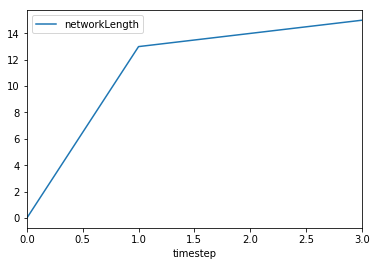

In [54]:
fig = plt.figure(figsize=(21,12))
full_df.plot('timestep', 'networkLength')
